# Visualizations and Samples
In this notebook, we will be taking a look at the samples that are generated by the Variational Autoencoders (VAEs) trained in this repo. VAEs are generative models that are widely used in machine learning for tasks such as data generation, representation learning, and more. We'll explore how these models encode and decode data, allowing us to sample from and visualize their latent spaces.

## 1. Load Models
In this section, we'll load pre-trained VAEs built with Pyro, a probabilistic programming framework. These models have been trained on the FashionMNIST dataset and are ready for sampling and exploration. We'll import the necessary libraries and load the trained models into our notebook environment, preparing them for further analysis.

In [1]:
import dill
from fashion_mnist_vae.utils import utils, constants

from torchvision.datasets import FashionMNIST
import numpy as np
import torch
from PIL import Image
import pyro

/home/giulia/.cache/pypoetry/virtualenvs/fashion-mnist-vae-8ZmQOx4R-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vae_path = constants.ASSETS_DIR.joinpath("vae", "model.pkl")
vae_con_path = constants.ASSETS_DIR.joinpath("vae_con", "model.pkl")

with vae_path.open("rb") as f:
    vae = dill.load(f)

with vae_con_path.open("rb") as f:
    vae_con = dill.load(f)

## 2. Sampling from Latent Space
Now that we have our VAEs loaded, we will sample from the learned latent spaces. For that purpose we will load the test images of the FashionMNIST datasets along with their labels. We will randomly choose 25 examples for which we will obtain the mean and standard deviation in the latent space. The latent space is intended to represent a compressed, continuous representation of the input data, where each point corresponds to a potential data instance. By sampling from this space, we can generate new data points that should inherit the characteristics learned by the models during training. 

Initially, we will look at simple decodings of conditional random samples from the latent space. Following that, we will explore what happens if we modify the standard deviation of a given sample. Lastly, we will investigate how the generated images morph, as we move from one conditional mean to the other.

In [3]:
# If you would like to generate different random samples, change the seed
rng = np.random.default_rng(seed=42)

# Select random images and labels from FashionMNIST testing set
test_set = FashionMNIST(train=False, transform=utils.to_tensor, root=constants.ASSETS_DIR)
sample_indices = rng.choice(range(len(test_set)), 25, replace=False)
sample_test_images = torch.stack([test_set[i][0] for i in sample_indices], dim=0)
sample_test_labels = torch.tensor([test_set[i][1] for i in sample_indices])

# VAE
# Example images
vae_predictive = pyro.infer.Predictive(model=vae.model, guide=vae.guide, num_samples=1)
latent_space_samples = vae_predictive(sample_test_images)["latent_space"]
vae_images = []
for batch in latent_space_samples:
    generated_images = vae.decoder(batch).view(-1, 28, 28).detach().cpu().numpy() * 255
    vae_images.append(generated_images)

# Modified standard deviation
sample_image = sample_test_images[[0]]
z_loc, z_scale = vae.encoder(sample_image.to(vae.device))
z_scale_gradient = torch.cat([(z_scale * 0.1 * i + 1e-6) for i in np.arange(25)])
gradient_samples = pyro.distributions.Normal(z_loc, z_scale_gradient).sample()
gradient_images = vae.decoder(gradient_samples).view(-1, 28, 28).cpu().detach().numpy() * 255.

# Morp within latent space
sample_image_base = sample_test_images[[1]]
sample_image_target = sample_test_images[[2]]
z_loc_base, z_scale_base = vae.encoder(sample_image_base.to(vae.device))
z_loc_target, z_scale_target = vae.encoder(sample_image_target.to(vae.device))
loc_step, scale_step = (z_loc_target - z_loc_base) / 24, (z_scale_target - z_scale_base) / 24
z_loc = torch.cat([z_loc_base + loc_step*step for step in range(25)])
z_scale = torch.cat([z_scale_base + scale_step*step for step in range(25)])
morphing_samples = pyro.distributions.Normal(z_loc, z_scale).sample()
morphing_images = vae.decoder(morphing_samples).view(-1, 28, 28).cpu().detach().numpy() * 255.

# Conditional VAE
vae_con_predictive = pyro.infer.Predictive(model=vae_con.model, guide=vae_con.guide, num_samples=5)
latent_space_samples = vae_con_predictive(sample_test_images, sample_test_labels)["latent_space"]
vae_con_images = []
for batch in latent_space_samples:
    generated_images = vae_con.decoder(batch).view(-1, 28, 28).detach().cpu().numpy() * 255
    vae_con_images.append(generated_images)

/home/giulia/.cache/pypoetry/virtualenvs/fashion-mnist-vae-8ZmQOx4R-py3.11/lib64/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:78.)
  return F.conv2d(input, weight, bias, self.stride,


## 3. Visualizing Samples
In this final section, we'll visualize the samples generated from the latent space of our VAEs, using the PIL library.

## Original Images
For comparison, the original selected 25 test images are shown here.

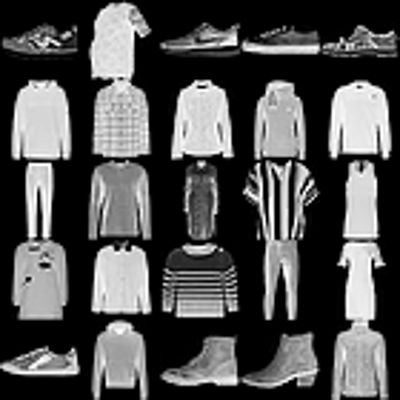

In [4]:
image_grid = utils.image_grid(sample_test_images.view(-1, 28, 28).cpu().numpy() * 255., rows=5, cols=5, gridsize=(400, 400))
display(image_grid)

### Latent Space Samples
Below are the same samples above when compressed into latent space and decompressed / sampled out of it. As we can see, the shapes of the objects are very well imitated, although there are no intricate patterns or details. There seems to be some attempt by the model to reproduce patterns of the input samples, but they are rather smudgy. In the world of fashion, that could very well be intended though.

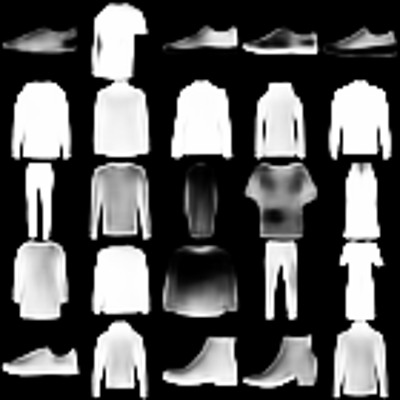

In [5]:
for images in vae_images:
    image_grid = utils.image_grid(images, rows=5, cols=5, gridsize=(400, 400))
    display(image_grid)

In [6]:
image_grid.save(constants.ROOT_DIR.joinpath(".github", "vae_examples.png").as_posix())

### Variation in Standard Deviation
Below, we can see what happens when the sample mean is held constant, while the standard deviation is slowly increased. At the lower end of the standard deviation, we see a very high similarity to the original image, while an increased standard deviation introduces variations into the generated image, until the decompressed sample becomes less and less like the original shoe.

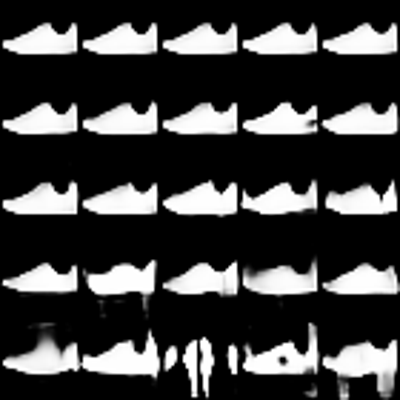

In [7]:
image_grid = utils.image_grid(gradient_images, rows=5, cols=5, gridsize=(400, 400))
display(image_grid)

### Morphing Images
Below we see what happens when both mean and standard deviation are slowly shifted from one encoded sample to another one.
As we can see quite clearly, the image shifts from a T-Shirt (top left) to a shoe (bottom right), quite gradually.

Interestingly, the original T-Shirt, does not seem to have a second sleeve on the left side. The model, however adds a long sleeve on the left, making the T-Shirt asymmetric (designers, write that down).

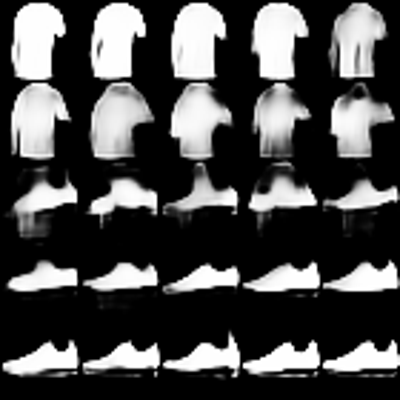

In [8]:
image_grid = utils.image_grid(morphing_images, rows=5, cols=5, gridsize=(400, 400))
display(image_grid)

In [9]:
image_grid.save(constants.ROOT_DIR.joinpath(".github", "morphing_images.png").as_posix())

### Samples from Alternative Model
Depicted below are samples generated from an alternative VAE architecture. The shape of objects is similarly well retained as in the previously discussed samples, however, the nature of the patterns is better reproduced in the generated samples.

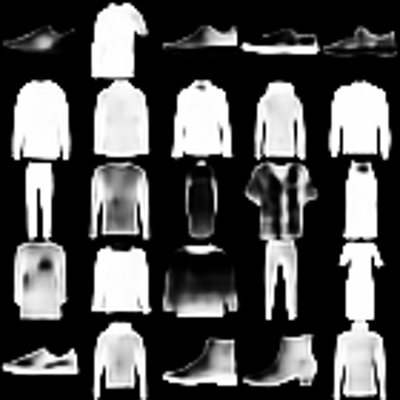

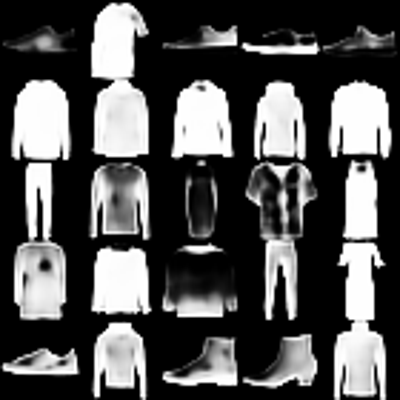

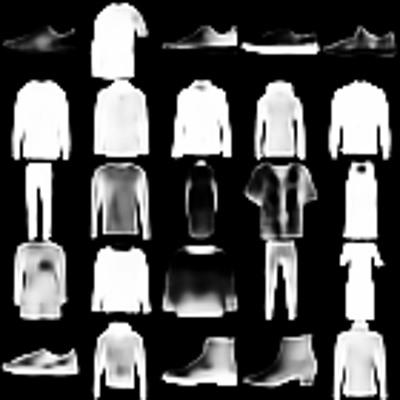

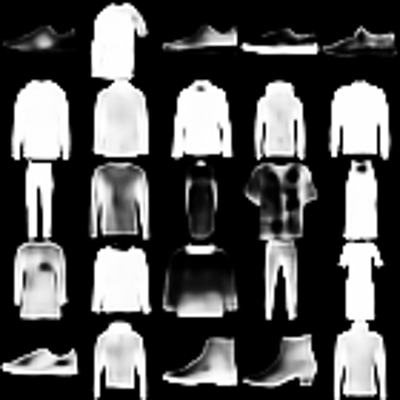

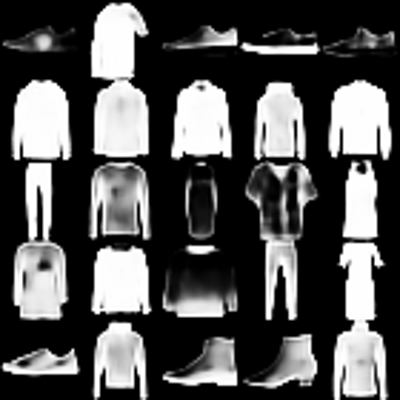

In [10]:
for images in vae_con_images:
    image_grid = utils.image_grid(images, rows=5, cols=5, gridsize=(400, 400))
    display(image_grid)